# ETL for CIS 9440 Data Warehousing and Analytics
- Project title: NYC Motor Vehicle Collision Transparency Data Warehouse Project 
- Final Project Milestone 3
- Group Number: 5 
- Version A: collision as a dimension
- Student(s): Gabriel Fernandez, Jason Jiang 

---

# ETL - Extract data

In [1]:
#Install the required python packages
# !pip install --upgrade sodapy

In [14]:
# pip install --upgrade sodapy
# pip install --upgrade db-dtypes
# pip install --upgrade pyarrow
# pip install --upgrade google-cloud-bigquery
#for progress bar
# pip install tqdm 

In [15]:
# import libraries
import pandas as pd
import numpy as np
from sodapy import Socrata
from google.cloud import bigquery
from google.oauth2 import service_account
from tqdm.notebook import tqdm_notebook # to show progress bar 
from IPython.display import Image # to attach images
pd.options.mode.chained_assignment = None  # default='warn'

## Data sets

### Dataset 1: Motor Vehicle Collisions - Crashes

he Motor Vehicle Collisions crash table contains details on the crash event. Each row represents a crash event. The Motor Vehicle Collisions data tables contain information from all police reported motor vehicle collisions in NYC. 

https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95




## Dataset 2: Motor Vehicle Collisions - Person 

The Motor Vehicle Collisions person table contains details for people involved in the crash. Each row represents a person (driver, occupant, pedestrian, bicyclist,..) involved in a crash. The data in this table goes back to April 2016 when crash reporting switched to an electronic system.
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu

---

- Get your app-token from: https://data.cityofnewyork.us/profile/edit/developer_settings






## Dimensional model (updated)
https://lucid.app/lucidchart/d42f0e3b-891b-49d3-9486-6ffabdc2f6d8/edit?page=0_0&invitationId=inv_b85589a9-5172-40f5-8ca8-450d9098461b# 


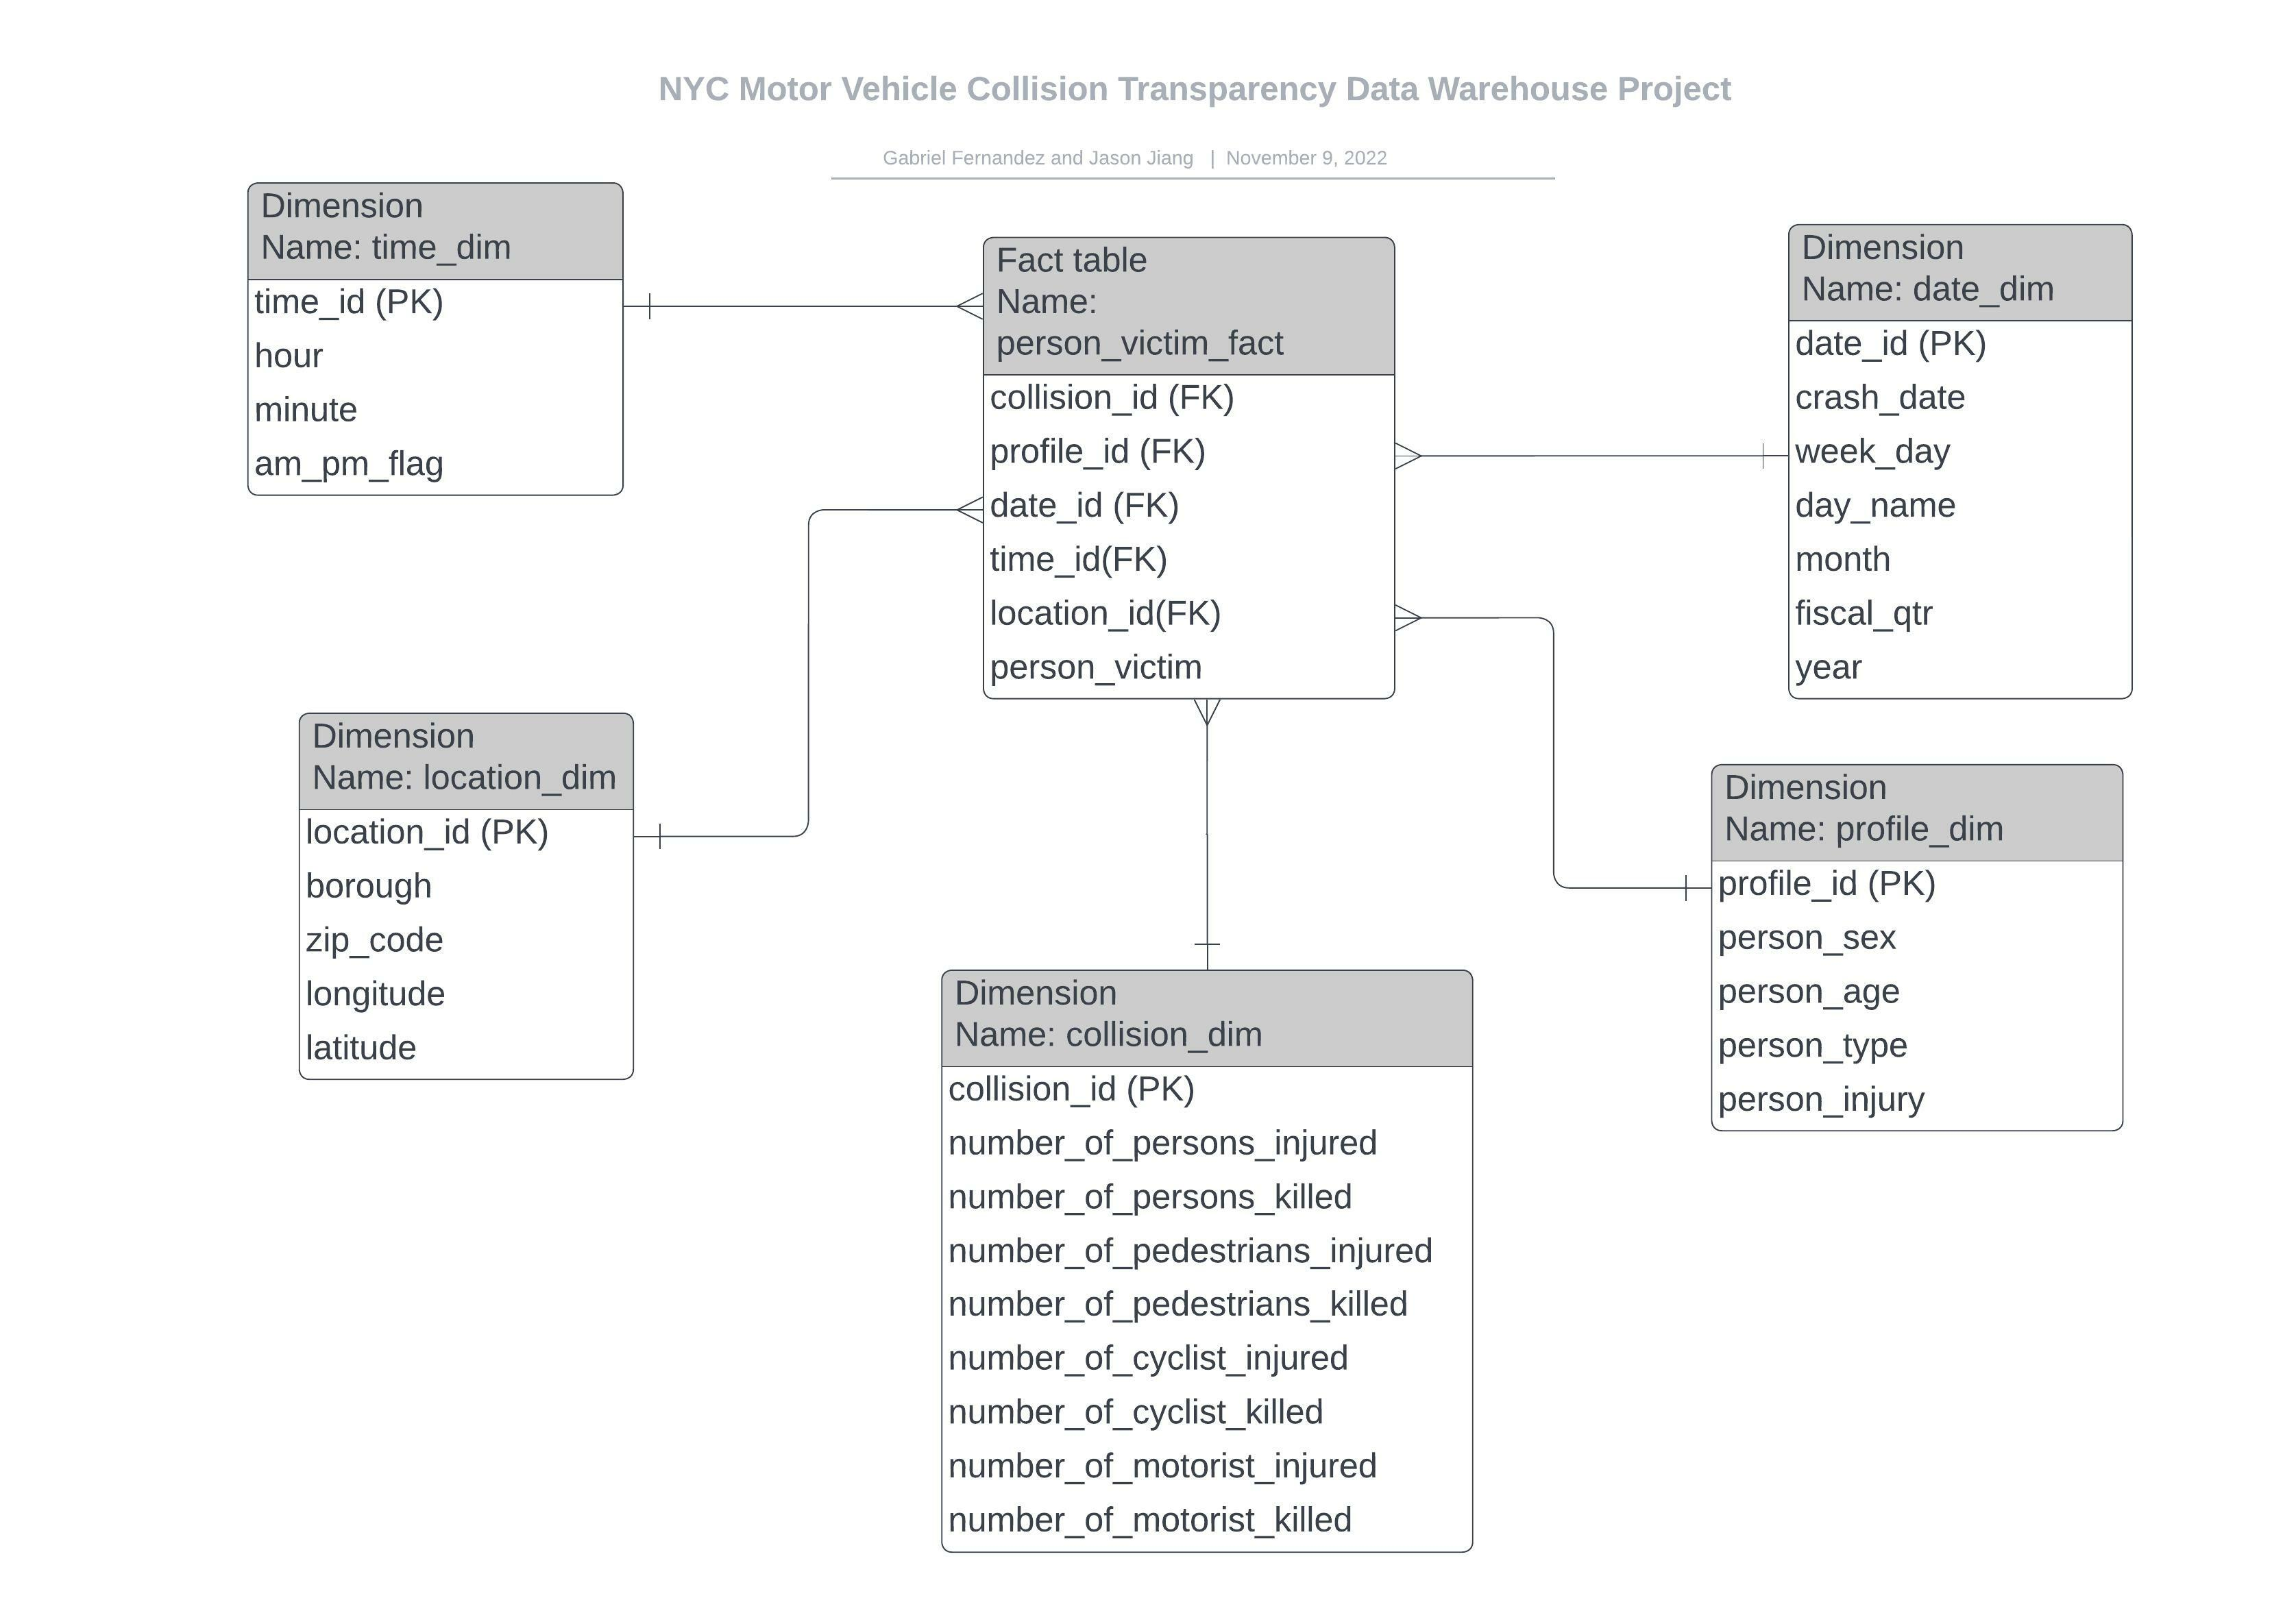

In [16]:
Image("/content/drive/MyDrive/project_DW/project_dimensional_model.jpeg")

In [17]:
# setup the host name for the API endpoint for NYC Open Data
data_url = 'data.cityofnewyork.us'

In [18]:
# setup the data sets at the API endpoint
 
# end point https://data.cityofnewyork.us/resource/t5n6-gx8c.json
data_set1 = 'h9gi-nx95'
data_set2 = 'f55k-p6yu'

In [19]:
# Setup your App Token
# You can find your app token by logging into: https://data.cityofnewyork.us/profile/edit/developer_settings
app_token = "your_token"

In [20]:
# run this cell to setup your Socrata client that connects python to NYC Open Data

# create the client that points to the API endpoint
nyc_open_data_client = Socrata(data_url, app_token, timeout = 200)
print(f"nyc open data client name is: {nyc_open_data_client}")
print(f"nyc open data client data type is: {type(nyc_open_data_client)}")

nyc open data client name is: <sodapy.socrata.Socrata object at 0x7f1ae17e8190>
nyc open data client data type is: <class 'sodapy.socrata.Socrata'>


In [21]:
# Define a key_path variable to connect BigQuery
key_path = "your.json"

In [22]:
# run this cell without changing anything to setup your credentials
credentials = service_account.Credentials.from_service_account_file(key_path,
                                                                    scopes=["https://www.googleapis.com/auth/cloud-platform"],)
bigquery_client = bigquery.Client(credentials = credentials,
                                 project = credentials.project_id)

print(f"bigquery client name is: {bigquery_client}")
print(f"bigquery client data type is: {type(bigquery_client)}")

bigquery client name is: <google.cloud.bigquery.client.Client object at 0x7f1ae189dfd0>
bigquery client data type is: <class 'google.cloud.bigquery.client.Client'>


In [23]:
# Create a new dataset in BigQuery and copy its id

dataset_id = "your_databasae_id"   

dataset_id = dataset_id.replace(':', '.')
print(f"your dataset_id is: {dataset_id}")

your dataset_id is: deft-stratum-361822.ETL_milestone3


## Extract data

1. connect to NYC Open Data with API Key
2. pull specific dataset as a pandas dataframe
3. Look at shape of extracted data

sodapy client.get parameters (https://dev.socrata.com/docs/:queries/)
1. select
2. where
3. order
4. limit
5. group
'

In [24]:
# Get the total number of records in our the entire data sets

#data_set1
total_record_count = nyc_open_data_client.get(data_set1, select = "COUNT(*)")
print(f"total records in {data_set1}: {total_record_count[0]['COUNT']}")


total records in h9gi-nx95: 1943446


In [25]:
#data_set2
total_record_count2 = nyc_open_data_client.get(data_set2, select = "COUNT(*)")
print(f"total records in {data_set2}: {total_record_count2[0]['COUNT']}")


total records in f55k-p6yu: 4857091


In [26]:
# Now, loop through target data set to pull all rows in chunks (we cannot pull all rows at once)
# Maximum chunk size for limit parameter is 50,000 https://dev.socrata.com/docs/queries/limit.html 

def extract_socrata_data(data_set,
                         chunk_size = 2500,
                         where = None):
    
    # measure time this function takes
    import time
    start_time1 = time.time()
    
    # get total number or records
    if where == None:
        total_records = int(nyc_open_data_client.get(data_set,
                                                     select= "COUNT(*)")[0]["COUNT"])
    else:
        total_records = int(nyc_open_data_client.get(data_set,
                                                     where = where,
                                                     select= "COUNT(*)")[0]["COUNT"])
    
    # start at 0, empty list for results
    start = 0                   
    results = []   
 
    # for progress bar
    pbar = tqdm_notebook(desc = 'while loop', total = total_records)

    while True:

        if where == None:
            # fetch the set of records starting at 'start'
            results.extend(nyc_open_data_client.get(data_set,
                                                    offset = start,
                                                    limit = chunk_size))
            
        elif where != None:
            results.extend(nyc_open_data_client.get(data_set,
                                                    where = where,
                                                    offset = start,
                                                    limit = chunk_size))
        # update the starting record number
        start = start + chunk_size
        
        # Update progress bar
        print(start, end ='\r')
        pbar.update(chunk_size)

        # if we have fetched all of the records (we have reached total_records), exit loop
        if (start > total_records):
            print("Loop completed")
            #close progress bar
            pbar.close()
            break

    # convert the list into a pandas data frame
    end_time1 = time.time()
    print(f"Loop took {round(end_time1 - start_time1, 1)} seconds")
    
    start_time2 = time.time()
    
    data = pd.DataFrame.from_records(results)

    end_time2 = time.time()
    print(f"Transforming to pandas.DataFrame took {round(end_time2 - start_time2, 1)} seconds")

    print(f"The shape of your dataframe is: {data.shape}")
    return data


 
# progress bar: https://medium.com/@harshit4084/track-your-loop-using-tqdm-7-ways-progress-bars-in-python-make-things-easier-fcbbb9233f24

In [27]:
# Fetch all rows for data set1

#data_set1 = 'h9gi-nx95'
data1 = extract_socrata_data(chunk_size = 10000,
                             data_set = data_set1)


while loop:   0%|          | 0/1943446 [00:00<?, ?it/s]

Loop completed
Loop took 338.4 seconds
Transforming to pandas.DataFrame took 10.1 seconds
The shape of your dataframe is: (1943446, 29)


In [28]:
data1.head()

,crash_date,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,latitude,longitude,location,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
0,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-26T00:00:00.000,11:45,QUEENSBORO BRIDGE UPPER,NaN,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-06-29T00:00:00.000,6:55,THROGS NECK BRIDGE,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-11T00:00:00.000,9:35,NaN,NaN,0,0,0,0,0,0,...,40.667202,-73.8665,"{'latitude': '40.667202', 'longitude': '-73.86...",1211 LORING AVENUE,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-12-14T00:00:00.000,8:13,SARATOGA AVENUE,DECATUR STREET,0,0,0,0,0,0,...,40.683304,-73.917274,"{'latitude': '40.683304', 'longitude': '-73.91...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Fetch all rows for data set2
#data_set2 = 'f55k-p6yu'
data2 = extract_socrata_data(data_set = data_set2,
                             chunk_size = 50000)



while loop:   0%|          | 0/4857091 [00:00<?, ?it/s]

Loop completed
Loop took 239.0 seconds
Transforming to pandas.DataFrame took 21.5 seconds
The shape of your dataframe is: (4857091, 21)


In [30]:
data1.columns


Index(['crash_date', 'crash_time', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'location', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5'],
      dtype='object')

In [31]:
data2.columns

Index(['unique_id', 'collision_id', 'crash_date', 'crash_time', 'person_id',
       'person_type', 'person_injury', 'vehicle_id', 'ped_role', 'person_sex',
       'person_age', 'ejection', 'emotional_status', 'bodily_injury',
       'position_in_vehicle', 'safety_equipment', 'complaint', 'ped_location',
       'ped_action', 'contributing_factor_1', 'contributing_factor_2'],
      dtype='object')

### Merge data 

In [32]:
data = data1.merge(data2,
                         how = 'inner',
                         left_on = "collision_id",
                         right_on = "collision_id")

In [33]:
data.shape

(4856938, 49)

In [34]:
data.head()

,crash_date_x,crash_time_x,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,ejection,emotional_status,bodily_injury,position_in_vehicle,safety_equipment,complaint,ped_location,ped_action,contributing_factor_1,contributing_factor_2
0,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,Not Ejected,Conscious,Back,Driver,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN
1,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,Not Ejected,Conscious,Back,"Front passenger, if two or more persons, inclu...",Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN
4,2022-03-26T00:00:00.000,11:45,QUEENSBORO BRIDGE UPPER,NaN,1,0,0,0,0,0,...,Not Ejected,Conscious,Shoulder - Upper Arm,Driver,Lap Belt & Harness,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN


# ETL - Transform data

## Data profiling

1. Distinct values per column
2. Null values per column
3. Summary statistics per numeric column

In [35]:
# what are the columns in our dataframe?
data.columns

Index(['crash_date_x', 'crash_time_x', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'location', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'unique_id',
       'crash_date_y', 'crash_time_y', 'person_id', 'person_type',
       'person_injury', 'vehicle_id', 'ped_role', 'person_sex', 'person_age',
       'ejection', 'emotional_status', 'bodily_injury', 'position_in_vehicle',
    

In [36]:
data.rename(columns = {'person_id':'person_victim','crash_date_x':'crash_date','crash_time_x':'crash_time'}, inplace = True)
data.columns

Index(['crash_date', 'crash_time', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'location', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'unique_id',
       'crash_date_y', 'crash_time_y', 'person_victim', 'person_type',
       'person_injury', 'vehicle_id', 'ped_role', 'person_sex', 'person_age',
       'ejection', 'emotional_status', 'bodily_injury', 'position_in_vehicle',
    

In [37]:
# create and run a function to ceate data profiling dataframe

def create_data_profiling_df(data):
    
    # create an empty dataframe to gather information about each column
    data_profiling_df = pd.DataFrame(columns = ["column_name",
                                                "column_type",
                                                "unique_values",
                                                "duplicate_values",
                                                "null_values",
                                                "non_null_values"])

    # loop through each column to add rows to the data_profiling_df dataframe
    for column in tqdm_notebook(data.columns):

        info_dict = {}

        try:
            info_dict["column_name"] = column
            info_dict["column_type"] = data[column].dtypes
            info_dict["unique_values"] = len(data[column].unique())
            info_dict["duplicate_values"] = data[column].count() - len(data[column].dropna().unique())
            info_dict["null_values"] = data[column].isna().sum()
            info_dict["non_null_values"] = data[column].count()

        except:
            print(f"unable to read column: {column}, you may want to drop this column")

        data_profiling_df = data_profiling_df.append(info_dict, ignore_index=True)

    data_profiling_df.sort_values(by = ['unique_values', "non_null_values"],
                                  ascending = [False, False],
                                  inplace=True)
    
    return data_profiling_df

In [38]:
# view your data profiling dataframe
#RUN DATA PROFILING FUNCTION HERE
data_profiling_df = create_data_profiling_df(data = data)
data_profiling_df

  0%|          | 0/49 [00:00<?, ?it/s]

unable to read column: location, you may want to drop this column


,column_name,column_type,unique_values,duplicate_values,null_values,non_null_values
29,unique_id,object,4851693,5245,0,4856938
32,person_victim,object,4656971,199949,19,4856919
35,vehicle_id,object,2236663,2427126,193150,4663788
14,collision_id,object,1313567,3543371,0,4856938
22,cross_street_name,object,184211,783511,3889217,967721
19,latitude,object,145775,4239911,471253,4385685
20,longitude,object,108374,4277312,471253,4385685
3,off_street_name,object,17464,2470852,2368623,2488315
2,on_street_name,object,16238,3834835,1005866,3851072
0,crash_date,object,3781,4853157,0,4856938


In [39]:
#drop location because it is a dictionary and will raise an error in the next sections. Also, we already have longitude and latitude.
data.drop(['location'], axis=1, inplace=True)

## Data cleaning 

1. drop unneeded columns
2. drop duplicate rows
3. check for outliers

In [40]:
# Run this to look at a list of your columns
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4856938 entries, 0 to 4856937
Data columns (total 48 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   crash_date                     object
 1   crash_time                     object
 2   on_street_name                 object
 3   off_street_name                object
 4   number_of_persons_injured      object
 5   number_of_persons_killed       object
 6   number_of_pedestrians_injured  object
 7   number_of_pedestrians_killed   object
 8   number_of_cyclist_injured      object
 9   number_of_cyclist_killed       object
 10  number_of_motorist_injured     object
 11  number_of_motorist_killed      object
 12  contributing_factor_vehicle_1  object
 13  contributing_factor_vehicle_2  object
 14  collision_id                   object
 15  vehicle_type_code1             object
 16  vehicle_type_code2             object
 17  borough                        object
 18  zip_code              

## Drop duplicates

In [41]:
def drop_dupli(data):
 
  #check number of rows
  print(f"number of rows before dropping duplicates: {len(data)}")
  #check for duplciates
  print(f"number of duplicate rows: {len(data[data.duplicated()])}")
  #drop duplicate rows based on entire row
  data = data.drop_duplicates(keep = 'first')
  print(f"number of rows after duplicates dropped: {len(data)}")
  
  return data


In [42]:
# drop duplicates 
data_sin_du = drop_dupli(data)

number of rows before dropping duplicates: 4856938
number of duplicate rows: 5245
number of rows after duplicates dropped: 4851693


In [43]:
data = data_sin_du.copy()
data.shape

(4851693, 48)

In [44]:
# update numeric columns types for data

select_cols = ['latitude',
               'longitude',
               'person_age',
               'collision_id',
               'number_of_persons_injured', 
               'number_of_persons_killed',
               'number_of_pedestrians_injured', 
               'number_of_pedestrians_killed',
               'number_of_cyclist_injured', 
               'number_of_cyclist_killed',
               'number_of_motorist_injured',
               'number_of_motorist_killed']

for column in tqdm_notebook(select_cols):
    try:
        data[column] = data[column].astype(int)
        
    except:
        data[column] = data[column].astype(float)
        
data.info()

  0%|          | 0/12 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4851693 entries, 0 to 4856937
Data columns (total 48 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   crash_date                     object 
 1   crash_time                     object 
 2   on_street_name                 object 
 3   off_street_name                object 
 4   number_of_persons_injured      float64
 5   number_of_persons_killed       float64
 6   number_of_pedestrians_injured  int64  
 7   number_of_pedestrians_killed   int64  
 8   number_of_cyclist_injured      int64  
 9   number_of_cyclist_killed       int64  
 10  number_of_motorist_injured     int64  
 11  number_of_motorist_killed      int64  
 12  contributing_factor_vehicle_1  object 
 13  contributing_factor_vehicle_2  object 
 14  collision_id                   int64  
 15  vehicle_type_code1             object 
 16  vehicle_type_code2             object 
 17  borough                        object 
 18  zi

## Check for outliers

In [45]:
# select numerics col for data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data_numerics= data.select_dtypes(include=numerics)

In [46]:
# Descriptive statistics for data
data_numerics.drop(columns=['latitude','longitude', 'collision_id']).describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_persons_injured,4851651.0,0.474809,1.017106,0.0,0.0,0.0,1.0,43.0
number_of_persons_killed,4851601.0,0.002248,0.054740,0.0,0.0,0.0,0.0,8.0
number_of_pedestrians_injured,4851693.0,0.051084,0.253341,0.0,0.0,0.0,0.0,27.0
number_of_pedestrians_killed,4851693.0,0.000970,0.034187,0.0,0.0,0.0,0.0,6.0
number_of_cyclist_injured,4851693.0,0.024411,0.156942,0.0,0.0,0.0,0.0,4.0
number_of_cyclist_killed,4851693.0,0.000161,0.013102,0.0,0.0,0.0,0.0,2.0
number_of_motorist_injured,4851693.0,0.396939,0.998329,0.0,0.0,0.0,0.0,43.0
number_of_motorist_killed,4851693.0,0.001101,0.038158,0.0,0.0,0.0,0.0,5.0
person_age,4368517.0,36.972675,118.444215,-999.0,23.0,35.0,50.0,9999.0


In [47]:
data.shape

(4851693, 48)

In [48]:
 # Filter out person_age < 0 and > 120
 data= data[(0 < data["person_age"]) & (data["person_age"] < 120)].copy()

In [49]:
data["person_age"].describe().T

count    3.818761e+06
mean     4.018684e+01
std      1.668717e+01
min      1.000000e+00
25%      2.800000e+01
50%      3.800000e+01
75%      5.200000e+01
max      1.190000e+02
Name: person_age, dtype: float64

In [50]:
data.shape

(3818761, 48)

## Create location dimension

In [51]:
# first, copy the entire table
location_dim = data.copy()

In [52]:
location_dim.columns

Index(['crash_date', 'crash_time', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'unique_id',
       'crash_date_y', 'crash_time_y', 'person_victim', 'person_type',
       'person_injury', 'vehicle_id', 'ped_role', 'person_sex', 'person_age',
       'ejection', 'emotional_status', 'bodily_injury', 'position_in_vehicle',
       'safety_e

In [53]:
# second, subset for only the wanted columns in the dimension
location_dim = location_dim[['borough', 'zip_code','latitude', 'longitude']]

In [54]:
# third, drop duplicate rows in dimension
# create unique row for dimension
unique_row = ['borough', 'zip_code','latitude', 'longitude']
#drop duplicates
location_dim = location_dim.drop_duplicates(subset = unique_row, keep = 'first')
#drop nulls
location_dim.dropna(inplace = True)
#reset index
location_dim = location_dim.reset_index(drop = True)
location_dim

,borough,zip_code,latitude,longitude
0,BROOKLYN,11208,40.667202,-73.866500
1,BROOKLYN,11233,40.683304,-73.917274
2,BRONX,10475,40.868160,-73.831480
3,MANHATTAN,10017,40.751440,-73.973970
4,QUEENS,11413,40.675884,-73.755770
...,...,...,...,...
205230,MANHATTAN,10013,40.723686,-74.004720
205231,BROOKLYN,11249,40.713642,-73.966070
205232,QUEENS,11432,40.718758,-73.800570
205233,QUEENS,11378,40.719110,-73.913216


In [55]:
# fourth, add location_id as a surrogate key
location_dim.insert(0, 'location_id', range(1, 1 + len(location_dim)))
location_dim


,location_id,borough,zip_code,latitude,longitude
0,1,BROOKLYN,11208,40.667202,-73.866500
1,2,BROOKLYN,11233,40.683304,-73.917274
2,3,BRONX,10475,40.868160,-73.831480
3,4,MANHATTAN,10017,40.751440,-73.973970
4,5,QUEENS,11413,40.675884,-73.755770
...,...,...,...,...,...
205230,205231,MANHATTAN,10013,40.723686,-74.004720
205231,205232,BROOKLYN,11249,40.713642,-73.966070
205232,205233,QUEENS,11432,40.718758,-73.800570
205233,205234,QUEENS,11378,40.719110,-73.913216


In [56]:
# fifth, add the location_id to the data table
data = data.merge(location_dim,
                  left_on = unique_row,
                  right_on = unique_row,
                  how = 'left')

data.head(100)

,crash_date,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,emotional_status,bodily_injury,position_in_vehicle,safety_equipment,complaint,ped_location,ped_action,contributing_factor_1,contributing_factor_2,location_id
0,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,...,Conscious,Back,Driver,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN
1,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,...,Conscious,Back,"Front passenger, if two or more persons, inclu...",Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN
3,2022-03-26T00:00:00.000,11:45,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,...,Conscious,Shoulder - Upper Arm,Driver,Lap Belt & Harness,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN
4,2022-03-26T00:00:00.000,11:45,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2021-07-09T00:00:00.000,0:43,ELIOT AVENUE,NaN,0.0,1.0,0,1,0,0,...,Apparent Death,Entire Body,NaN,NaN,Crush Injuries,Pedestrian/Bicyclist/Other Pedestrian Not at I...,Other Actions in Roadway,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,Unspecified,NaN
96,2021-07-09T00:00:00.000,0:43,ELIOT AVENUE,NaN,0.0,1.0,0,1,0,0,...,Does Not Apply,Does Not Apply,Driver,Lap Belt & Harness,Does Not Apply,NaN,NaN,NaN,NaN,NaN
97,2022-04-24T00:00:00.000,16:45,STATEN ISLAND EXPRESSWAY,NaN,1.0,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2022-04-24T00:00:00.000,16:45,STATEN ISLAND EXPRESSWAY,NaN,1.0,0.0,0,0,0,0,...,Does Not Apply,Does Not Apply,Driver,Lap Belt & Harness,Does Not Apply,NaN,NaN,NaN,NaN,NaN


In [57]:
data.shape

(3818761, 49)

## Create date dimension

In [58]:
# change to data data type
data['crash_date'] = pd.to_datetime(data['crash_date'])
#get the date portion 
data['crash_date']= data['crash_date'].dt.floor('D')
data['crash_date']

0         2021-09-11
1         2021-09-11
2         2021-09-11
3         2022-03-26
4         2022-03-26
             ...    
3818756   2022-11-02
3818757   2022-11-06
3818758   2022-11-06
3818759   2022-11-06
3818760   2022-11-06
Name: crash_date, Length: 3818761, dtype: datetime64[ns]

In [59]:
## ACTION REQUIRED: update the start and end date at the bottom of the sql_query variable to fit your needs

sql_query = """
            SELECT
              CONCAT (FORMAT_DATE("%Y",d),FORMAT_DATE("%m",d),FORMAT_DATE("%d",d)) as date_id,
              d AS crash_date,
              FORMAT_DATE('%w', d) AS week_day,
              FORMAT_DATE('%A', d) AS day_name,
              FORMAT_DATE('%B', d) as month,
              FORMAT_DATE('%Q', d) as fiscal_qtr,
              FORMAT_DATE('%Y', d) AS year,
            FROM (
              SELECT
                *
              FROM
                UNNEST(GENERATE_DATE_ARRAY('2012-07-01', '2024-01-01', INTERVAL 1 DAY)) AS d )
            """

# store extracted data in new dataframe
date_dim = bigquery_client.query(sql_query).to_dataframe()

# validate that > 0 rows have been extracted and return dataframe
if len(date_dim) > 0:
    print(f"date dimension created successfully, shape of dimension: {date_dim.shape}")
else:
    print("date dimension FAILED")

date dimension created successfully, shape of dimension: (4202, 7)


In [60]:
#check date_dim
date_dim.head()

,date_id,crash_date,week_day,day_name,month,fiscal_qtr,year
0,20120701,2012-07-01,0,Sunday,July,3,2012
1,20120702,2012-07-02,1,Monday,July,3,2012
2,20120703,2012-07-03,2,Tuesday,July,3,2012
3,20120704,2012-07-04,3,Wednesday,July,3,2012
4,20120705,2012-07-05,4,Thursday,July,3,2012


In [61]:
date_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4202 entries, 0 to 4201
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date_id     4202 non-null   object
 1   crash_date  4202 non-null   object
 2   week_day    4202 non-null   object
 3   day_name    4202 non-null   object
 4   month       4202 non-null   object
 5   fiscal_qtr  4202 non-null   object
 6   year        4202 non-null   object
dtypes: object(7)
memory usage: 229.9+ KB


In [62]:
# convert date_id to int
date_dim['date_id'] = date_dim['date_id'].astype(int)
date_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4202 entries, 0 to 4201
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date_id     4202 non-null   int64 
 1   crash_date  4202 non-null   object
 2   week_day    4202 non-null   object
 3   day_name    4202 non-null   object
 4   month       4202 non-null   object
 5   fiscal_qtr  4202 non-null   object
 6   year        4202 non-null   object
dtypes: int64(1), object(6)
memory usage: 229.9+ KB


In [63]:
# create date_id column in the Fact Table
data['date_id'] = data['crash_date'].apply(lambda x: pd.to_datetime(x).strftime("%Y%m%d"))

In [64]:
#check date_dim
data.head()

,crash_date,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,bodily_injury,position_in_vehicle,safety_equipment,complaint,ped_location,ped_action,contributing_factor_1,contributing_factor_2,location_id,date_id
0,2021-09-11,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,...,Back,Driver,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911
1,2021-09-11,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210911
2,2021-09-11,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,...,Back,"Front passenger, if two or more persons, inclu...",Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911
3,2022-03-26,11:45,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,...,Shoulder - Upper Arm,Driver,Lap Belt & Harness,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20220326
4,2022-03-26,11:45,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220326


In [65]:
data.shape

(3818761, 50)

In [66]:
# Drop date from complete dataset.
data.drop("crash_date", axis = 1, inplace = True)

In [67]:
data.shape

(3818761, 49)

## Create time dimension

In [68]:
time_ids = []
hours = []
minutes = []

for hour in range(0,24):
    for minute in range(0,60):
        time_ids.append((str(hour) + str(minute)).zfill(4))
        hours.append(hour)
        minutes.append(minute)
        
time_dim_dict = {"time_id" : time_ids,
                "hour" : hours,
                "minute" : minutes}

time_dim = pd.DataFrame(data = time_dim_dict)

In [69]:
# add a column for AM and PM
time_dim['am_pm_flag'] = np.where(time_dim['hour'] >= 12,'PM','AM')

In [70]:
time_dim

,time_id,hour,minute,am_pm_flag
0,0000,0,0,AM
1,0001,0,1,AM
2,0002,0,2,AM
3,0003,0,3,AM
4,0004,0,4,AM
...,...,...,...,...
1435,2355,23,55,PM
1436,2356,23,56,PM
1437,2357,23,57,PM
1438,2358,23,58,PM


In [71]:
time_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   time_id     1440 non-null   object
 1   hour        1440 non-null   int64 
 2   minute      1440 non-null   int64 
 3   am_pm_flag  1440 non-null   object
dtypes: int64(2), object(2)
memory usage: 45.1+ KB


In [72]:
# Convert time_id ot int
time_dim['time_id'] = time_dim['time_id'].astype(int)
time_dim.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   time_id     1440 non-null   int64 
 1   hour        1440 non-null   int64 
 2   minute      1440 non-null   int64 
 3   am_pm_flag  1440 non-null   object
dtypes: int64(3), object(1)
memory usage: 45.1+ KB


In [73]:
# Remove ":"" from crash time
data["crash_time"]

0           2:39
1           2:39
2           2:39
3          11:45
4          11:45
           ...  
3818756    21:48
3818757     5:00
3818758     5:00
3818759     5:00
3818760     5:00
Name: crash_time, Length: 3818761, dtype: object

In [74]:
data["crash_time"] = data["crash_time"].replace({':': ''}, regex=True).str.strip()

In [75]:
data["crash_time"]

0           239
1           239
2           239
3          1145
4          1145
           ... 
3818756    2148
3818757     500
3818758     500
3818759     500
3818760     500
Name: crash_time, Length: 3818761, dtype: object

In [76]:
# USE ZFILL AND PAD here to make time_id
data["crash_time"] = data["crash_time"].str.zfill(2).str.pad(4, side = "right", fillchar = "0")

In [77]:
# check fact table progress
data.head()

,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,bodily_injury,position_in_vehicle,safety_equipment,complaint,ped_location,ped_action,contributing_factor_1,contributing_factor_2,location_id,date_id
0,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,Back,Driver,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911
1,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210911
2,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,Back,"Front passenger, if two or more persons, inclu...",Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911
3,1145,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,1,...,Shoulder - Upper Arm,Driver,Lap Belt & Harness,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20220326
4,1145,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220326


In [78]:
data.rename(columns = {'crash_time':'time_id'}, inplace = True)
data["time_id"]

0          2390
1          2390
2          2390
3          1145
4          1145
           ... 
3818756    2148
3818757    5000
3818758    5000
3818759    5000
3818760    5000
Name: time_id, Length: 3818761, dtype: object

## Create collision dimension

In [79]:
# Create person dimension from data2
data.head()

,time_id,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,bodily_injury,position_in_vehicle,safety_equipment,complaint,ped_location,ped_action,contributing_factor_1,contributing_factor_2,location_id,date_id
0,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,Back,Driver,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911
1,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210911
2,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,Back,"Front passenger, if two or more persons, inclu...",Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911
3,1145,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,1,...,Shoulder - Upper Arm,Driver,Lap Belt & Harness,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20220326
4,1145,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220326


In [80]:
data.shape

(3818761, 49)

In [81]:
backup = data.copy()

In [82]:
# first, copy the entire table
collision_dim= data.copy()

In [83]:
collision_dim.columns

Index(['time_id', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'unique_id',
       'crash_date_y', 'crash_time_y', 'person_victim', 'person_type',
       'person_injury', 'vehicle_id', 'ped_role', 'person_sex', 'person_age',
       'ejection', 'emotional_status', 'bodily_injury', 'position_in_vehicle',
       'safety_equipment', 'compl

In [84]:
# second, subset for only the wanted columns in the dimension
collision_dim= collision_dim[['collision_id',
                               'number_of_persons_injured', 
                               'number_of_persons_killed',
                               'number_of_pedestrians_injured', 
                               'number_of_pedestrians_killed',
                               'number_of_cyclist_injured', 
                               'number_of_cyclist_killed',
                               'number_of_motorist_injured',
                               'number_of_motorist_killed']].copy()

In [85]:
collision_dim.shape

(3818761, 9)

In [86]:
# third, drop duplicate rows in dimension
# create unique row for dimension

unique_row = ['collision_id',
              'number_of_persons_injured', 
              'number_of_persons_killed',
              'number_of_pedestrians_injured', 
              'number_of_pedestrians_killed',
              'number_of_cyclist_injured', 
              'number_of_cyclist_killed',
              'number_of_motorist_injured',
              'number_of_motorist_killed']
# drop duplicates
collision_dim = collision_dim.drop_duplicates(subset = unique_row, keep = 'first').copy()
#drop nulls
collision_dim.dropna(inplace = True)
collision_dim = collision_dim.reset_index(drop = True)
collision_dim

,collision_id,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed
0,4455765,2.0,0.0,0,0,0,0,2,0
1,4513547,1.0,0.0,0,0,0,0,1,0
2,4541903,0.0,0.0,0,0,0,0,0,0
3,4456314,0.0,0.0,0,0,0,0,0,0
4,4486609,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1263546,4579631,0.0,0.0,0,0,0,0,0,0
1263547,4580066,1.0,0.0,1,0,0,0,0,0
1263548,4580080,0.0,0.0,0,0,0,0,0,0
1263549,4580097,1.0,0.0,0,0,0,0,1,0


In [87]:
collision_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263551 entries, 0 to 1263550
Data columns (total 9 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   collision_id                   1263551 non-null  int64  
 1   number_of_persons_injured      1263551 non-null  float64
 2   number_of_persons_killed       1263551 non-null  float64
 3   number_of_pedestrians_injured  1263551 non-null  int64  
 4   number_of_pedestrians_killed   1263551 non-null  int64  
 5   number_of_cyclist_injured      1263551 non-null  int64  
 6   number_of_cyclist_killed       1263551 non-null  int64  
 7   number_of_motorist_injured     1263551 non-null  int64  
 8   number_of_motorist_killed      1263551 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 86.8 MB


In [88]:
#convert to correct type
collision_dim['number_of_persons_injured'] = collision_dim['number_of_persons_injured'].astype(int)
collision_dim['number_of_persons_killed']= collision_dim['number_of_persons_killed'].astype(int)

In [89]:
collision_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263551 entries, 0 to 1263550
Data columns (total 9 columns):
 #   Column                         Non-Null Count    Dtype
---  ------                         --------------    -----
 0   collision_id                   1263551 non-null  int64
 1   number_of_persons_injured      1263551 non-null  int64
 2   number_of_persons_killed       1263551 non-null  int64
 3   number_of_pedestrians_injured  1263551 non-null  int64
 4   number_of_pedestrians_killed   1263551 non-null  int64
 5   number_of_cyclist_injured      1263551 non-null  int64
 6   number_of_cyclist_killed       1263551 non-null  int64
 7   number_of_motorist_injured     1263551 non-null  int64
 8   number_of_motorist_killed      1263551 non-null  int64
dtypes: int64(9)
memory usage: 86.8 MB


In [90]:
collision_dim.shape

(1263551, 9)

In [91]:
# fourth, add collision_id as a surrogate key
collision_dim.insert(0, 'collision_id_surrogate', range(1, 1 + len(collision_dim)))
collision_dim

,collision_id_surrogate,collision_id,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed
0,1,4455765,2,0,0,0,0,0,2,0
1,2,4513547,1,0,0,0,0,0,1,0
2,3,4541903,0,0,0,0,0,0,0,0
3,4,4456314,0,0,0,0,0,0,0,0
4,5,4486609,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1263546,1263547,4579631,0,0,0,0,0,0,0,0
1263547,1263548,4580066,1,0,1,0,0,0,0,0
1263548,1263549,4580080,0,0,0,0,0,0,0,0
1263549,1263550,4580097,1,0,0,0,0,0,1,0


In [92]:
data.columns

Index(['time_id', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'unique_id',
       'crash_date_y', 'crash_time_y', 'person_victim', 'person_type',
       'person_injury', 'vehicle_id', 'ped_role', 'person_sex', 'person_age',
       'ejection', 'emotional_status', 'bodily_injury', 'position_in_vehicle',
       'safety_equipment', 'compl

In [93]:
# fifth, add the new  collision_id to the data table
data = data.merge(collision_dim,
                  left_on = unique_row,
                  right_on = unique_row,
                  how = 'left')

In [94]:
data.shape

(3818761, 50)

In [95]:
collision_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263551 entries, 0 to 1263550
Data columns (total 10 columns):
 #   Column                         Non-Null Count    Dtype
---  ------                         --------------    -----
 0   collision_id_surrogate         1263551 non-null  int64
 1   collision_id                   1263551 non-null  int64
 2   number_of_persons_injured      1263551 non-null  int64
 3   number_of_persons_killed       1263551 non-null  int64
 4   number_of_pedestrians_injured  1263551 non-null  int64
 5   number_of_pedestrians_killed   1263551 non-null  int64
 6   number_of_cyclist_injured      1263551 non-null  int64
 7   number_of_cyclist_killed       1263551 non-null  int64
 8   number_of_motorist_injured     1263551 non-null  int64
 9   number_of_motorist_killed      1263551 non-null  int64
dtypes: int64(10)
memory usage: 96.4 MB


In [96]:
#drop collision_id from collision_dim
collision_dim.drop('collision_id', axis = 1, inplace = True)


In [97]:
collision_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1263551 entries, 0 to 1263550
Data columns (total 9 columns):
 #   Column                         Non-Null Count    Dtype
---  ------                         --------------    -----
 0   collision_id_surrogate         1263551 non-null  int64
 1   number_of_persons_injured      1263551 non-null  int64
 2   number_of_persons_killed       1263551 non-null  int64
 3   number_of_pedestrians_injured  1263551 non-null  int64
 4   number_of_pedestrians_killed   1263551 non-null  int64
 5   number_of_cyclist_injured      1263551 non-null  int64
 6   number_of_cyclist_killed       1263551 non-null  int64
 7   number_of_motorist_injured     1263551 non-null  int64
 8   number_of_motorist_killed      1263551 non-null  int64
dtypes: int64(9)
memory usage: 86.8 MB


In [98]:
#change name of collision_id_surrogate to collision_id 
collision_dim.rename(columns = {'collision_id_surrogate':'collision_id'}, inplace = True)

In [99]:
collision_dim.head()

,collision_id,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed
0,1,2,0,0,0,0,0,2,0
1,2,1,0,0,0,0,0,1,0
2,3,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0


## Create profile dimension

In [100]:
# first, copy the entire table
profile_dim = data.copy()

In [101]:
profile_dim.columns

Index(['time_id', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'unique_id',
       'crash_date_y', 'crash_time_y', 'person_victim', 'person_type',
       'person_injury', 'vehicle_id', 'ped_role', 'person_sex', 'person_age',
       'ejection', 'emotional_status', 'bodily_injury', 'position_in_vehicle',
       'safety_equipment', 'compl

In [102]:
# second, subset for only the wanted columns in the dimension
profile_dim = profile_dim[['person_sex', 'person_age', 'person_type','person_injury']].copy()

 

In [103]:
# third, drop duplicate rows in dimension
# create unique row for dimension
unique_row = ['person_sex', 'person_age', 'person_type','person_injury']
profile_dim = profile_dim.drop_duplicates(subset = unique_row, keep = 'first')
profile_dim = profile_dim.reset_index(drop = True)
profile_dim

,person_sex,person_age,person_type,person_injury
0,M,29.0,Occupant,Injured
1,M,25.0,Occupant,Unspecified
2,M,33.0,Occupant,Injured
3,F,28.0,Occupant,Injured
4,M,29.0,Occupant,Unspecified
...,...,...,...,...
2715,M,5.0,Other Motorized,Injured
2716,F,67.0,Other Motorized,Killed
2717,F,80.0,Occupant,Killed
2718,F,59.0,Other Motorized,Unspecified


In [104]:
# fourth, add profile_id as a surrogate key
profile_dim.insert(0, 'profile_id', range(1, 1 + len(profile_dim)))
profile_dim

,profile_id,person_sex,person_age,person_type,person_injury
0,1,M,29.0,Occupant,Injured
1,2,M,25.0,Occupant,Unspecified
2,3,M,33.0,Occupant,Injured
3,4,F,28.0,Occupant,Injured
4,5,M,29.0,Occupant,Unspecified
...,...,...,...,...,...
2715,2716,M,5.0,Other Motorized,Injured
2716,2717,F,67.0,Other Motorized,Killed
2717,2718,F,80.0,Occupant,Killed
2718,2719,F,59.0,Other Motorized,Unspecified


In [105]:
# fifth, add the profile_id to the data table
data = data.merge(profile_dim,
                  left_on = unique_row,
                  right_on = unique_row,
                  how = 'left')

data.head(100)

,time_id,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,safety_equipment,complaint,ped_location,ped_action,contributing_factor_1,contributing_factor_2,location_id,date_id,collision_id_surrogate,profile_id
0,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911,1.0,1
1,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210911,1.0,2
2,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911,1.0,3
3,1145,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,1,...,Lap Belt & Harness,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20220326,2.0,4
4,1145,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220326,2.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0430,ELIOT AVENUE,NaN,0.0,1.0,0,1,0,0,0,...,NaN,Crush Injuries,Pedestrian/Bicyclist/Other Pedestrian Not at I...,Other Actions in Roadway,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,Unspecified,NaN,20210709,36.0,66
96,0430,ELIOT AVENUE,NaN,0.0,1.0,0,1,0,0,0,...,Lap Belt & Harness,Does Not Apply,NaN,NaN,NaN,NaN,NaN,20210709,36.0,67
97,1645,STATEN ISLAND EXPRESSWAY,NaN,1.0,0.0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220424,37.0,68
98,1645,STATEN ISLAND EXPRESSWAY,NaN,1.0,0.0,0,0,0,0,1,...,Lap Belt & Harness,Does Not Apply,NaN,NaN,NaN,NaN,NaN,20220424,37.0,6


## Create fact table for person_victim

In [106]:
data.head()

,time_id,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,safety_equipment,complaint,ped_location,ped_action,contributing_factor_1,contributing_factor_2,location_id,date_id,collision_id_surrogate,profile_id
0,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911,1.0,1
1,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210911,1.0,2
2,2390,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,0,0,2,...,Lap Belt,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20210911,1.0,3
3,1145,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,1,...,Lap Belt & Harness,Complaint of Pain or Nausea,NaN,NaN,NaN,NaN,NaN,20220326,2.0,4
4,1145,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220326,2.0,5


In [107]:
data.shape

(3818761, 51)

In [108]:
data.columns

Index(['time_id', 'on_street_name', 'off_street_name',
       'number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed',
       'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2',
       'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'borough',
       'zip_code', 'latitude', 'longitude', 'cross_street_name',
       'contributing_factor_vehicle_3', 'vehicle_type_code_3',
       'contributing_factor_vehicle_4', 'vehicle_type_code_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_5', 'unique_id',
       'crash_date_y', 'crash_time_y', 'person_victim', 'person_type',
       'person_injury', 'vehicle_id', 'ped_role', 'person_sex', 'person_age',
       'ejection', 'emotional_status', 'bodily_injury', 'position_in_vehicle',
       'safety_equipment', 'compl

In [109]:
# take a subset of fact_table for only the needed columns: which are keys and measures
fact_table = data[['collision_id_surrogate', 'profile_id', 'date_id','time_id','location_id','person_victim']].copy()

In [110]:
fact_table.shape

(3818761, 6)

In [111]:
fact_table.dropna(inplace = True)

In [112]:
fact_table.shape

(2234475, 6)

In [113]:
fact_table.head()

,collision_id_surrogate,profile_id,date_id,time_id,location_id,person_victim
7,4.0,8,20210911,9350,1.0,3cb21800-426f-47c8-a79e-fb65f2d2115e
8,4.0,8,20210911,9350,1.0,d7bbe88a-d44d-4155-8076-923b24b371be
9,5.0,9,20211214,8130,2.0,49b837fa-d00c-40a2-8af1-31ea2ce302f2
14,8.0,12,20211214,8170,3.0,a1699487-c586-4e1b-bf8c-a08cf53e331a
15,8.0,13,20211214,8170,3.0,1519c5d0-94a1-4dde-9f62-5311797ec6a2


In [114]:
fact_table = drop_dupli(fact_table)

number of rows before dropping duplicates: 2234475
number of duplicate rows: 0
number of rows after duplicates dropped: 2234475


In [115]:
fact_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2234475 entries, 7 to 3818756
Data columns (total 6 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   collision_id_surrogate  float64
 1   profile_id              int64  
 2   date_id                 object 
 3   time_id                 object 
 4   location_id             float64
 5   person_victim           object 
dtypes: float64(2), int64(1), object(3)
memory usage: 119.3+ MB


In [116]:
# change to proper type


for column in ['collision_id_surrogate',
               'profile_id',
               'date_id', 
               'time_id',
               'location_id', 
               'person_victim']:
    try:
        fact_table[column] = fact_table[column].astype(int)
        
    except:
        fact_table[column] = fact_table[column].astype(object)


In [117]:
fact_table.rename(columns = {'collision_id_surrogate':'collision_id'}, inplace = True)
fact_table.head()

,collision_id,profile_id,date_id,time_id,location_id,person_victim
7,4,8,20210911,9350,1,3cb21800-426f-47c8-a79e-fb65f2d2115e
8,4,8,20210911,9350,1,d7bbe88a-d44d-4155-8076-923b24b371be
9,5,9,20211214,8130,2,49b837fa-d00c-40a2-8af1-31ea2ce302f2
14,8,12,20211214,8170,3,a1699487-c586-4e1b-bf8c-a08cf53e331a
15,8,13,20211214,8170,3,1519c5d0-94a1-4dde-9f62-5311797ec6a2


In [118]:
fact_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2234475 entries, 7 to 3818756
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   collision_id   int64 
 1   profile_id     int64 
 2   date_id        int64 
 3   time_id        int64 
 4   location_id    int64 
 5   person_victim  object
dtypes: int64(5), object(1)
memory usage: 119.3+ MB


In [119]:
fact_table = fact_table.reset_index(drop = True)
fact_table.head()

,collision_id,profile_id,date_id,time_id,location_id,person_victim
0,4,8,20210911,9350,1,3cb21800-426f-47c8-a79e-fb65f2d2115e
1,4,8,20210911,9350,1,d7bbe88a-d44d-4155-8076-923b24b371be
2,5,9,20211214,8130,2,49b837fa-d00c-40a2-8af1-31ea2ce302f2
3,8,12,20211214,8170,3,a1699487-c586-4e1b-bf8c-a08cf53e331a
4,8,13,20211214,8170,3,1519c5d0-94a1-4dde-9f62-5311797ec6a2


# ETL - Load data

## Deliver Facts and Dimensions to Data Warehouse (BigQuery)

In [120]:
# create a function to load dataframes to BigQuery

def load_table_to_bigquery(df,
                          table_name,
                          dataset_id):

    dataset_id = dataset_id #change dataset id to match your project id

    dataset_ref = bigquery_client.dataset(dataset_id)
    job_config = bigquery.LoadJobConfig()
    job_config.autodetect = True
    job_config.write_disposition = "WRITE_TRUNCATE"

    upload_table_name = f"{dataset_id}.{table_name}"
    
    load_job = bigquery_client.load_table_from_dataframe(df,
                                                upload_table_name,
                                                job_config = job_config)
        
    print(f"completed job {load_job} for table {table_name}")

In [135]:
#Load each table to BigQuery: "fact_table", "date_dim", "location_dim", "time_dim", and "person_dim."

tables_objects = [[fact_table, "person_victim_fact"], [date_dim,"date_dim" ],
                  [location_dim,"location_dim"], [time_dim,"time_dim"],
                  [profile_dim,"profile_dim"],[collision_dim,"collision_dim"]
                  ]

In [136]:
for table in tables_objects:
    load_table_to_bigquery(df = table[0],
                       table_name = table[1],
                       dataset_id = dataset_id)

completed job <google.cloud.bigquery.job.LoadJob object at 0x7f192a3cc890> for table person_victim_fact
completed job <google.cloud.bigquery.job.LoadJob object at 0x7f192a354f10> for table date_dim
completed job <google.cloud.bigquery.job.LoadJob object at 0x7f192a3cc790> for table location_dim
completed job <google.cloud.bigquery.job.LoadJob object at 0x7f192a378910> for table time_dim
completed job <google.cloud.bigquery.job.LoadJob object at 0x7f192a3bfcd0> for table profile_dim
completed job <google.cloud.bigquery.job.LoadJob object at 0x7f192a3ca1d0> for table collision_dim


## Screenshots of database tables

### Date dimension

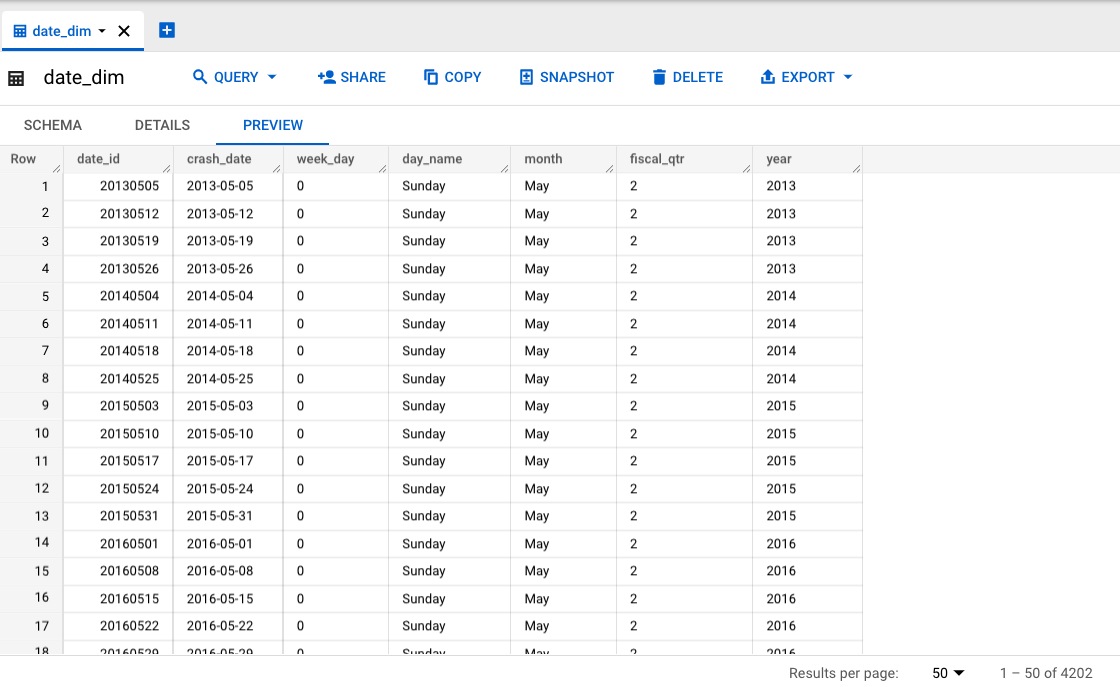

In [123]:
Image("/content/drive/MyDrive/project_DW/date_dim.png")



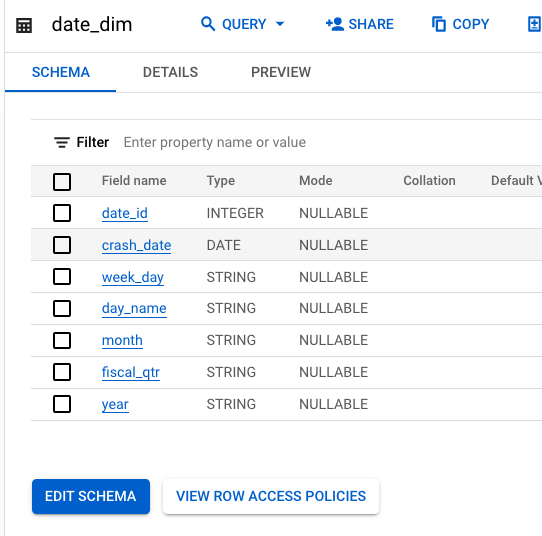

In [124]:

Image("/content/drive/MyDrive/project_DW/date_dim_types.png")

### Time dimension

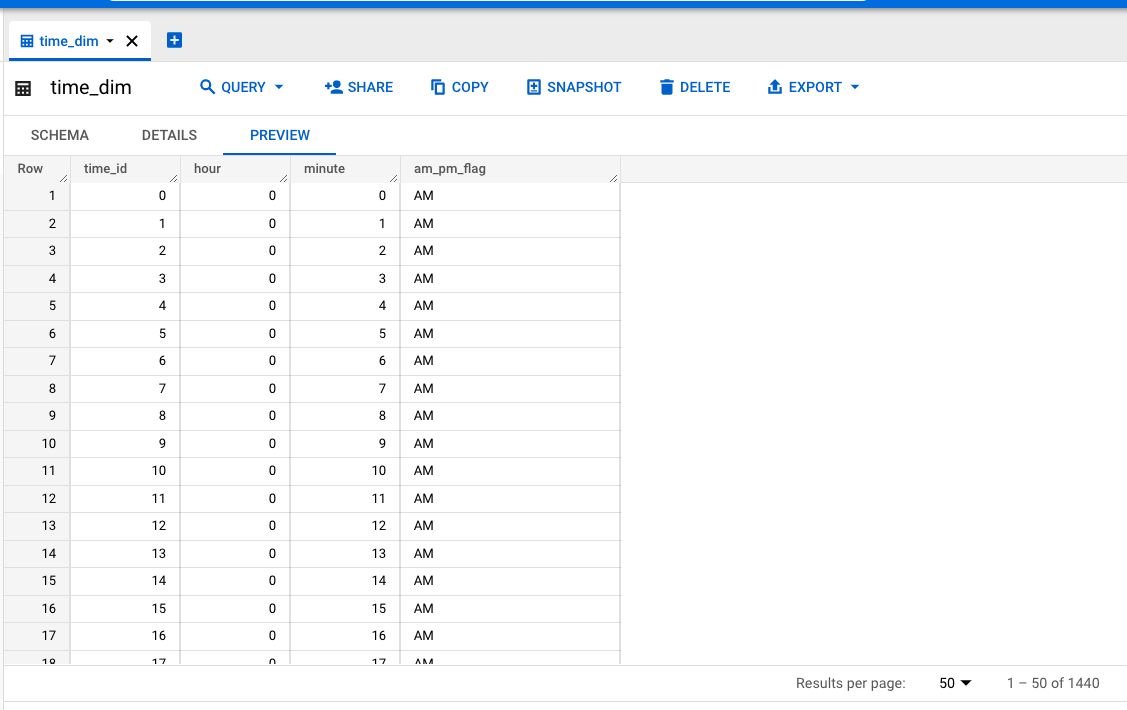

In [125]:
Image("/content/drive/MyDrive/project_DW/time_dim.png")

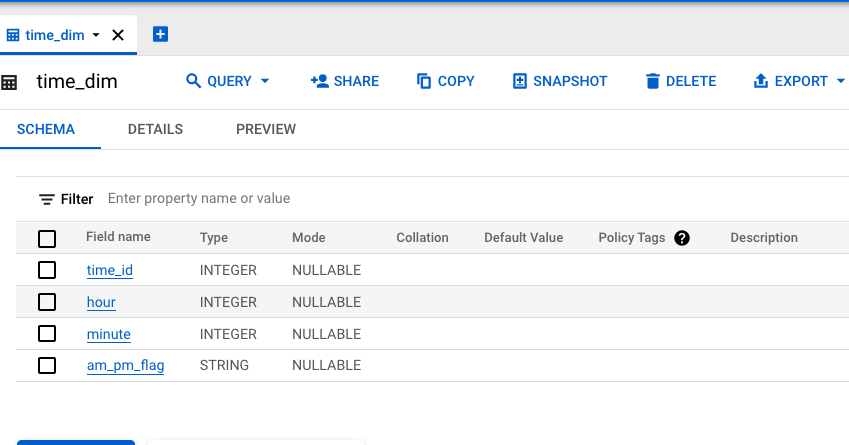

In [126]:
Image("/content/drive/MyDrive/project_DW/time_dim_types.png")

### Collision dimension

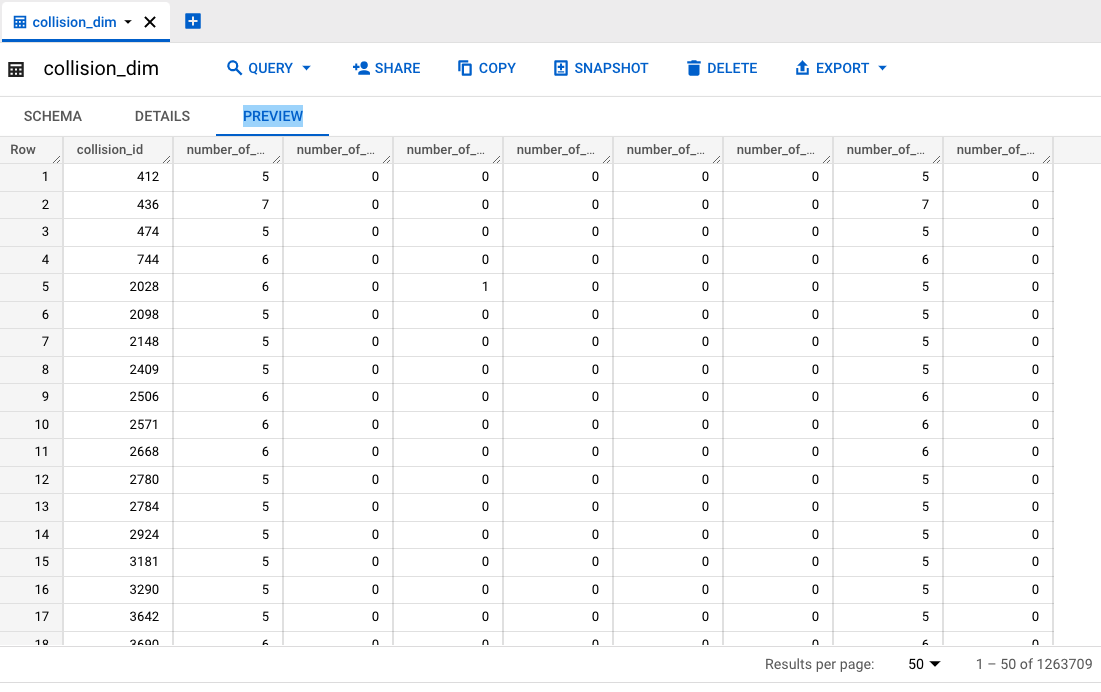

In [127]:
Image("/content/drive/MyDrive/project_DW/collision_dim.png")

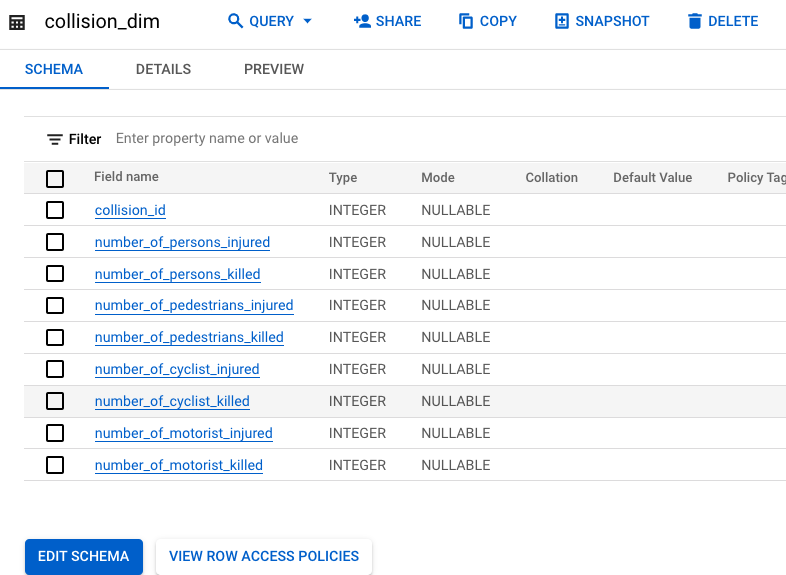

In [128]:
Image("/content/drive/MyDrive/project_DW/collision_dim_types.png")

### Location dimension

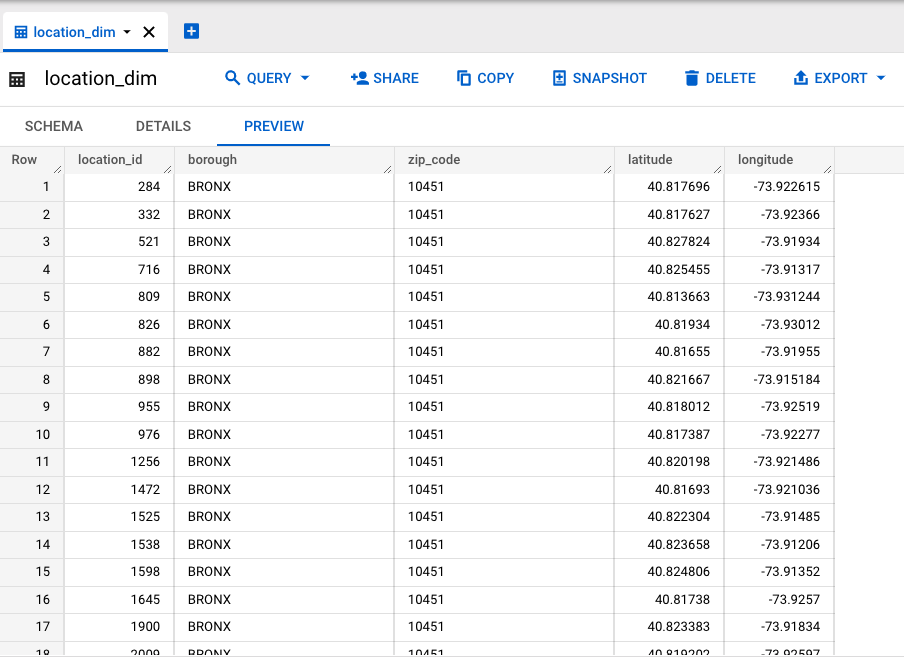

In [129]:
Image("/content/drive/MyDrive/project_DW/location_dim.png")

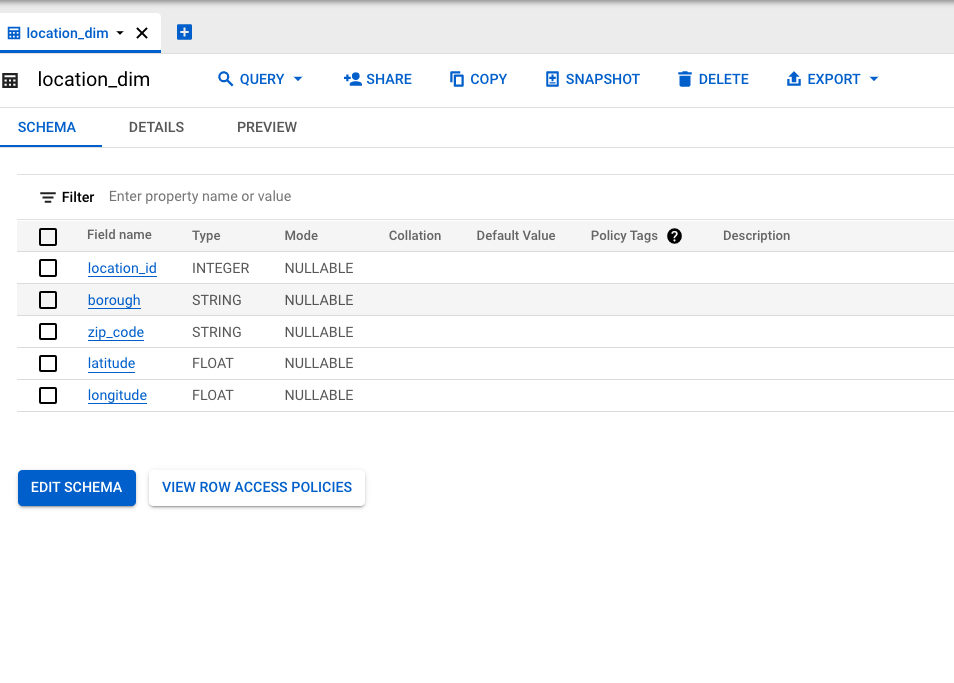

In [130]:
Image("/content/drive/MyDrive/project_DW/location_dim_types.png")

### Profile dimension

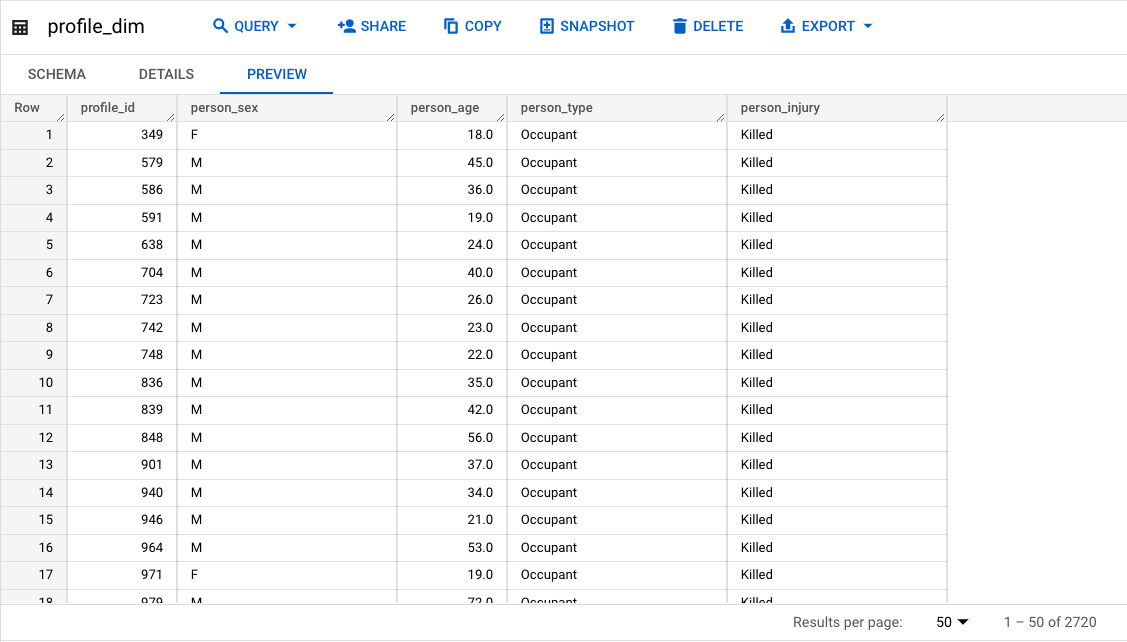

In [131]:
Image("/content/drive/MyDrive/project_DW/profile_dim.png")

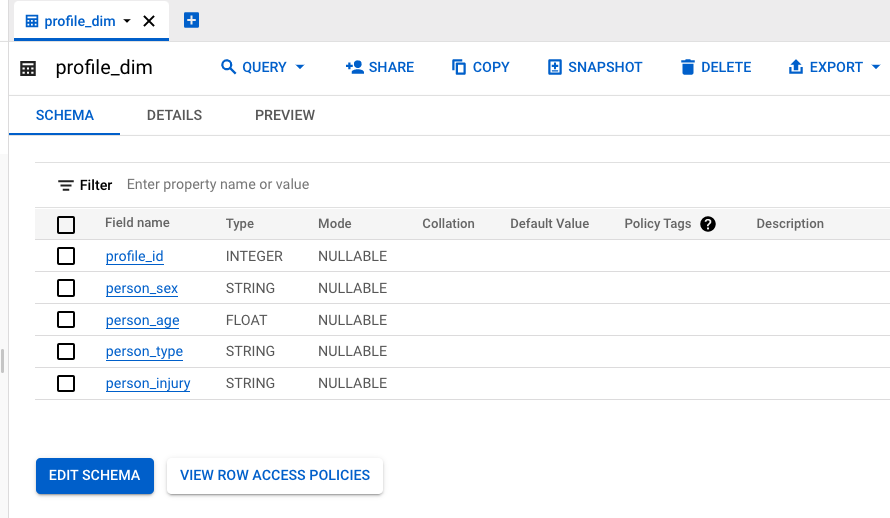

In [132]:
Image("/content/drive/MyDrive/project_DW/profile_dim_types.png")

### Fact table for person_victim_fact

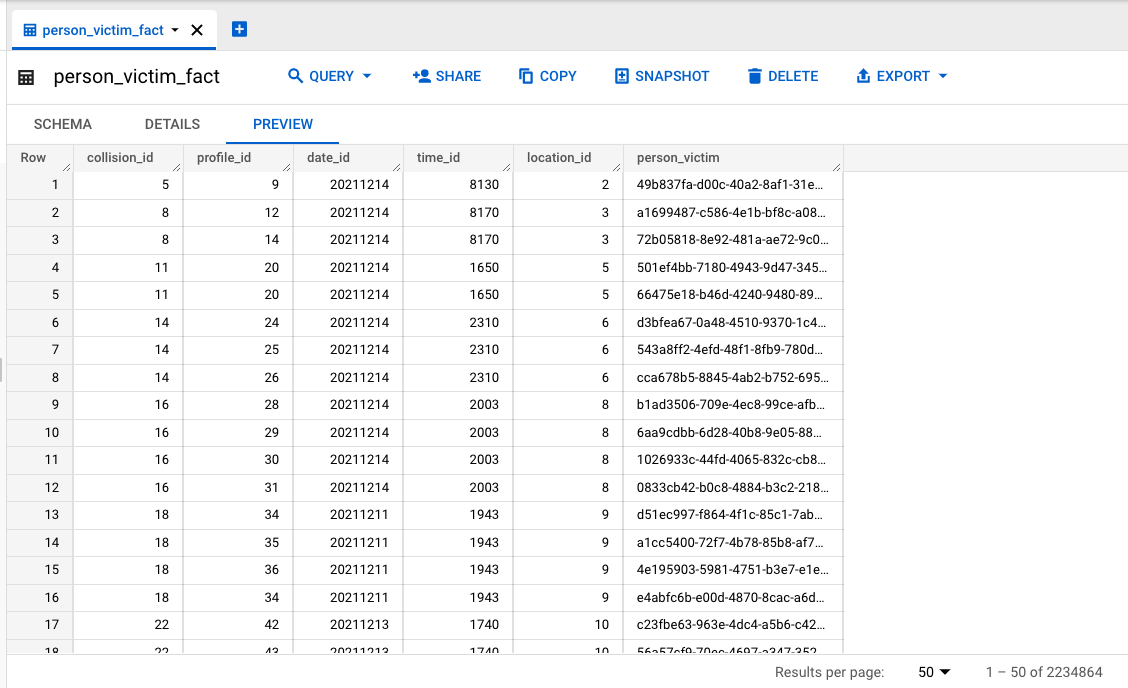

In [133]:
Image("/content/drive/MyDrive/project_DW/person_victim_fact.png")

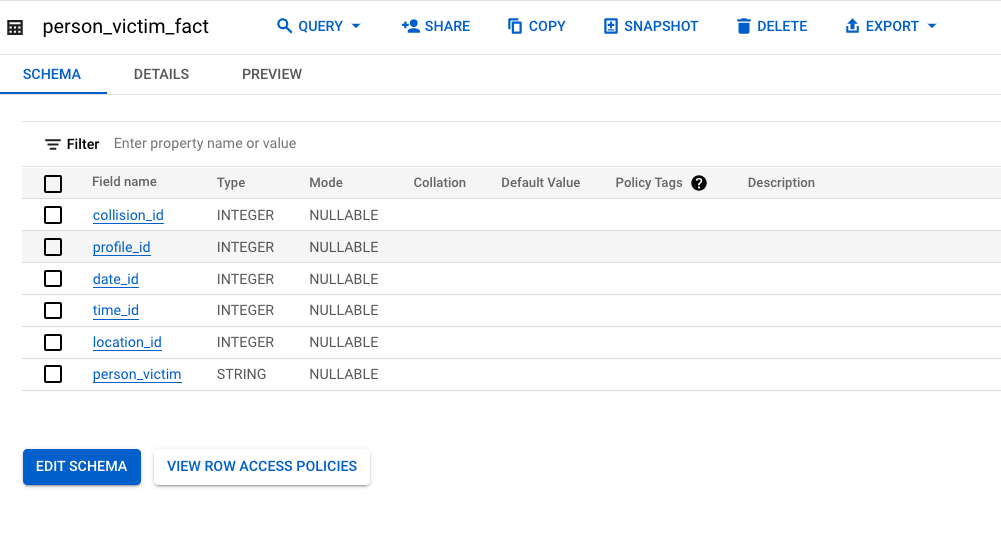

In [134]:
Image("/content/drive/MyDrive/project_DW/person_victim_fact_types.png")

## References

- ETL Pipeline tutorial by Michael O’Donnell (CIS 9440 Data Warehousing and Analytics).

- Track your loop using tqdm: 7 ways progress bars in Python make things easier: https://medium.com/@harshit4084/track-your-loop-using-tqdm-7-ways-progress-bars-in-python-make-things-easier-fcbbb9233f24 